# Results

## Pair dispersion

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
scripts_path = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
sys.path.append(scripts_path)
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories_optimized, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair
import pandas as pd

from datetime import date
import os
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.trajectory import Trajectory

In [3]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=20)
rc("axes", labelsize=20)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [4]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [5]:
base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"


spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

spot_l2_df['deploy_date'] = pd.to_datetime(spot_l2_df['deploy_time']).dt.date

date_deployment_1 = date(2025, 5, 12)
date_deployment_2 = date(2025, 5, 18)
date_deployment_3 = date(2025, 5, 24)
date_deployment_4 = date(2025, 5, 30)

drifters_deployment_1 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_1]['drifter_id'].unique()
drifters_deployment_2 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_2]['drifter_id'].unique()
drifters_deployment_3 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_3]['drifter_id'].unique()
drifters_deployment_4 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_4]['drifter_id'].unique()


def create_trajectories_and_times_list(drifters_id, spot_l2_df):
    traj_list = []
    for i in range(len(drifters_id)):
        drifter_id = drifters_id[i]
        df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

        traj = Trajectory.from_array(
            jnp.stack((jnp.asarray(df['lat']), jnp.asarray(df['lon'])), axis=-1), 
            jnp.asarray(np.asarray(df['time']).astype("datetime64[s]").astype(int)))
        traj_list.append(traj)

    traj_times = []
    for traj in traj_list:
        traj_times.append(np.asarray(traj.times.value).astype("datetime64[s]"))
    return traj_list, traj_times

traj_list_1, traj_times_1 = create_trajectories_and_times_list(drifters_deployment_1, spot_l2_df)
traj_list_2, traj_times_2 = create_trajectories_and_times_list(drifters_deployment_2, spot_l2_df)
traj_list_3, traj_times_3 = create_trajectories_and_times_list(drifters_deployment_3, spot_l2_df)
traj_list_4, traj_times_4 = create_trajectories_and_times_list(drifters_deployment_4, spot_l2_df)



dt = 30*60 # in seconds
ts_1 = np.arange(date_deployment_1, np.datetime64('now'), np.timedelta64(30,'m'))
ts_2 = np.arange(date_deployment_2, np.datetime64('now'), np.timedelta64(30,'m'))
ts_3 = np.arange(date_deployment_3, np.datetime64('now'), np.timedelta64(30,'m'))
ts_4 = np.arange(date_deployment_4, np.datetime64('now'), np.timedelta64(30,'m'))

masks_time_1 = create_mask_trajectories_optimized(traj_list_1, traj_times_1, ts_1)
masks_time_2 = create_mask_trajectories_optimized(traj_list_2, traj_times_2, ts_2)
masks_time_3 = create_mask_trajectories_optimized(traj_list_3, traj_times_3, ts_3)
masks_time_4 = create_mask_trajectories_optimized(traj_list_4, traj_times_4, ts_4)

interpolated_trajs_1 = temporal_interpolation(traj_list_1, masks_time_1, ts_1, traj_times_1)
interpolated_trajs_2 = temporal_interpolation(traj_list_2, masks_time_2, ts_2, traj_times_2)
interpolated_trajs_3 = temporal_interpolation(traj_list_3, masks_time_3, ts_3, traj_times_3)
interpolated_trajs_4 = temporal_interpolation(traj_list_4, masks_time_4, ts_4, traj_times_4)

Ds_1, Ks_1, mask_pair_1 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_1, masks_time_1, dt)
Ds_2, Ks_2, mask_pair_2 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_2, masks_time_2, dt)
Ds_3, Ks_3, mask_pair_3 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_3, masks_time_3, dt)
Ds_4, Ks_4, mask_pair_4 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_4, masks_time_4, dt)


We used the home-made SPOT drifters to study pair dispersion. They are designed to transmit their position every 30 minutes. However, this is not always the case. In order to calculate the distance betwen a pair of drifters, they should have transmitted in the same time interval. @fig-pair-masks shows in black when each drifter transmitted its position, using a time interval of 30 minutes. This trajectories have already been interpolated in time (L2 version). For each deployment of $N=5$ drifters, there are $N(N-1)/2 = 10$ pairs. For each pair, we will consider their positions if they transmitted at the same time interval. 

Considering the variability of the conditions for making *in-situ* measurements, each group of drifters behave differently. We can observe that there are several pairs for the first and third depoyments, but less simultaneous transmissions for the second and fourth. For example, on the last deployment one drifter stop transmitting almost inmediately, so we have only 6 pairs. But if we take a closer look at @fig-pair-masks (d) we see that in practice we have only one pair of drifters that transmitted for more than a month.

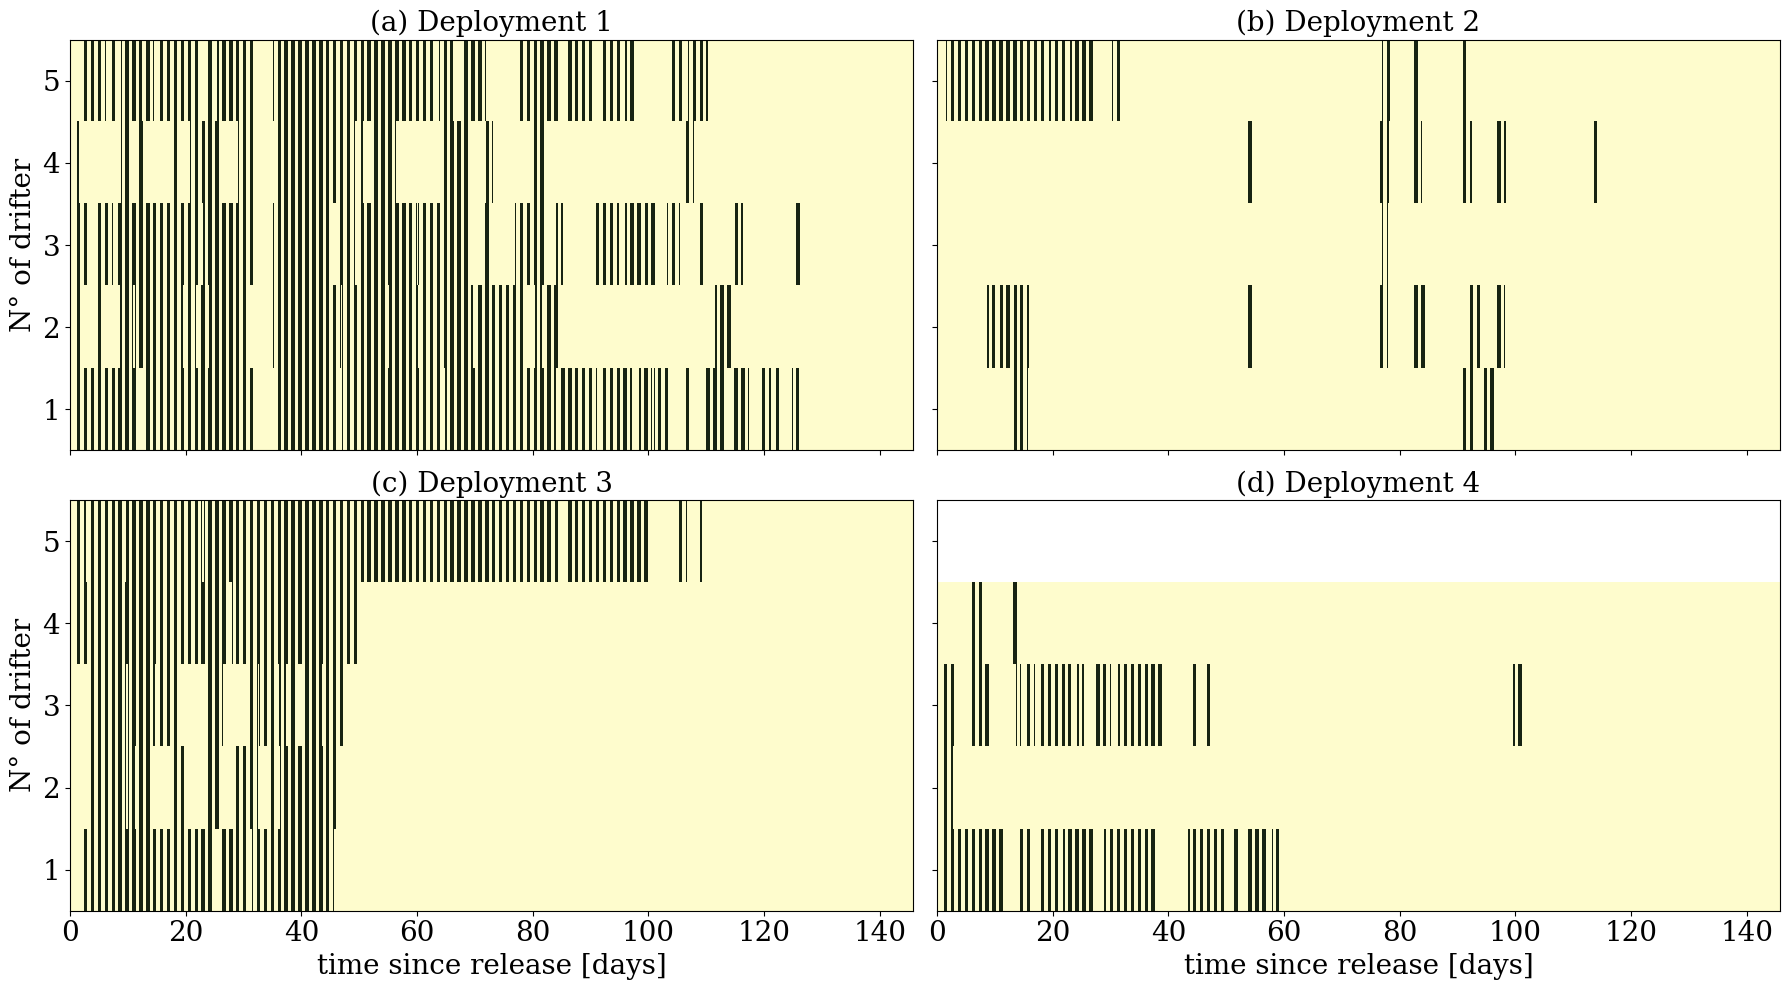

In [15]:
#| label: fig-pair-masks
#| fig-cap: "Mask showing if the drifters transmitted their position. The black rectangles indicate that the transmission was successful, yellow rectangles indicate that they did not transmit. L2 trajectories are used for the analysis. "

fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (18,10))

ax[0,0].imshow(masks_time_1, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_1.shape[1]*30/1440, 0.50, masks_time_1.shape[0] + 0.5))
ax[0,1].imshow(masks_time_2, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_2.shape[1]*30/1440, 0.50, masks_time_2.shape[0] + 0.5))
ax[1,0].imshow(masks_time_3, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_3.shape[1]*30/1440, 0.50, masks_time_3.shape[0] + 0.5))
ax[1,1].imshow(masks_time_4, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_4.shape[1]*30/1440, 0.50, masks_time_4.shape[0] + 0.5))

ax[0,0].set_title('(a) Deployment 1', fontsize = 20)
ax[0,1].set_title('(b) Deployment 2', fontsize = 20)
ax[1,0].set_title('(c) Deployment 3', fontsize = 20)
ax[1,1].set_title('(d) Deployment 4', fontsize = 20)

ax[0,0].set_ylabel('N° of drifter')
ax[1,0].set_ylabel('N° of drifter')

ax[0,0].set_ylim(0.5, masks_time_1.shape[0] + 0.5)

ax[1,0].set_xlabel('time since release [days]')
ax[1,1].set_xlabel('time since release [days]')

plt.tight_layout()
plt.show()

@fig-pair-dispersion shows the pair dispersion $D^2$ as a function of time for each deployment. As discussed before, for the first and third deployments we have several pairs while we do not have enough data for the second and fourth. In @fig-pair-dispersion (a) we can clearly observe two different behaviors: an exponential growth for the first two weeks after release, and a different regime after. Pink lines indicate the exponential and the Richardson regimes, showing a good agreement with the measured data. The third deployment, however, seems to show only an exponential behavior. It follows a scaling law $D^2 \propto e^{ \alpha t}$, with $\alpha = 5$. <span style="color: red;">comment on that</span>

In [17]:
index_plot_D = ['(a)', '(b)', '(c)', '(d)']
index_plot_K = ['(a)', '(b)', '(c)', '(d)']

datasets = [
    (Ds_1, Ks_1, mask_pair_1, ts_1, interpolated_trajs_1),
    (Ds_2, Ks_2, mask_pair_2, ts_2, interpolated_trajs_2),
    (Ds_3, Ks_3, mask_pair_3, ts_3, interpolated_trajs_3),
    (Ds_4, Ks_4, mask_pair_4, ts_4, interpolated_trajs_4)
]


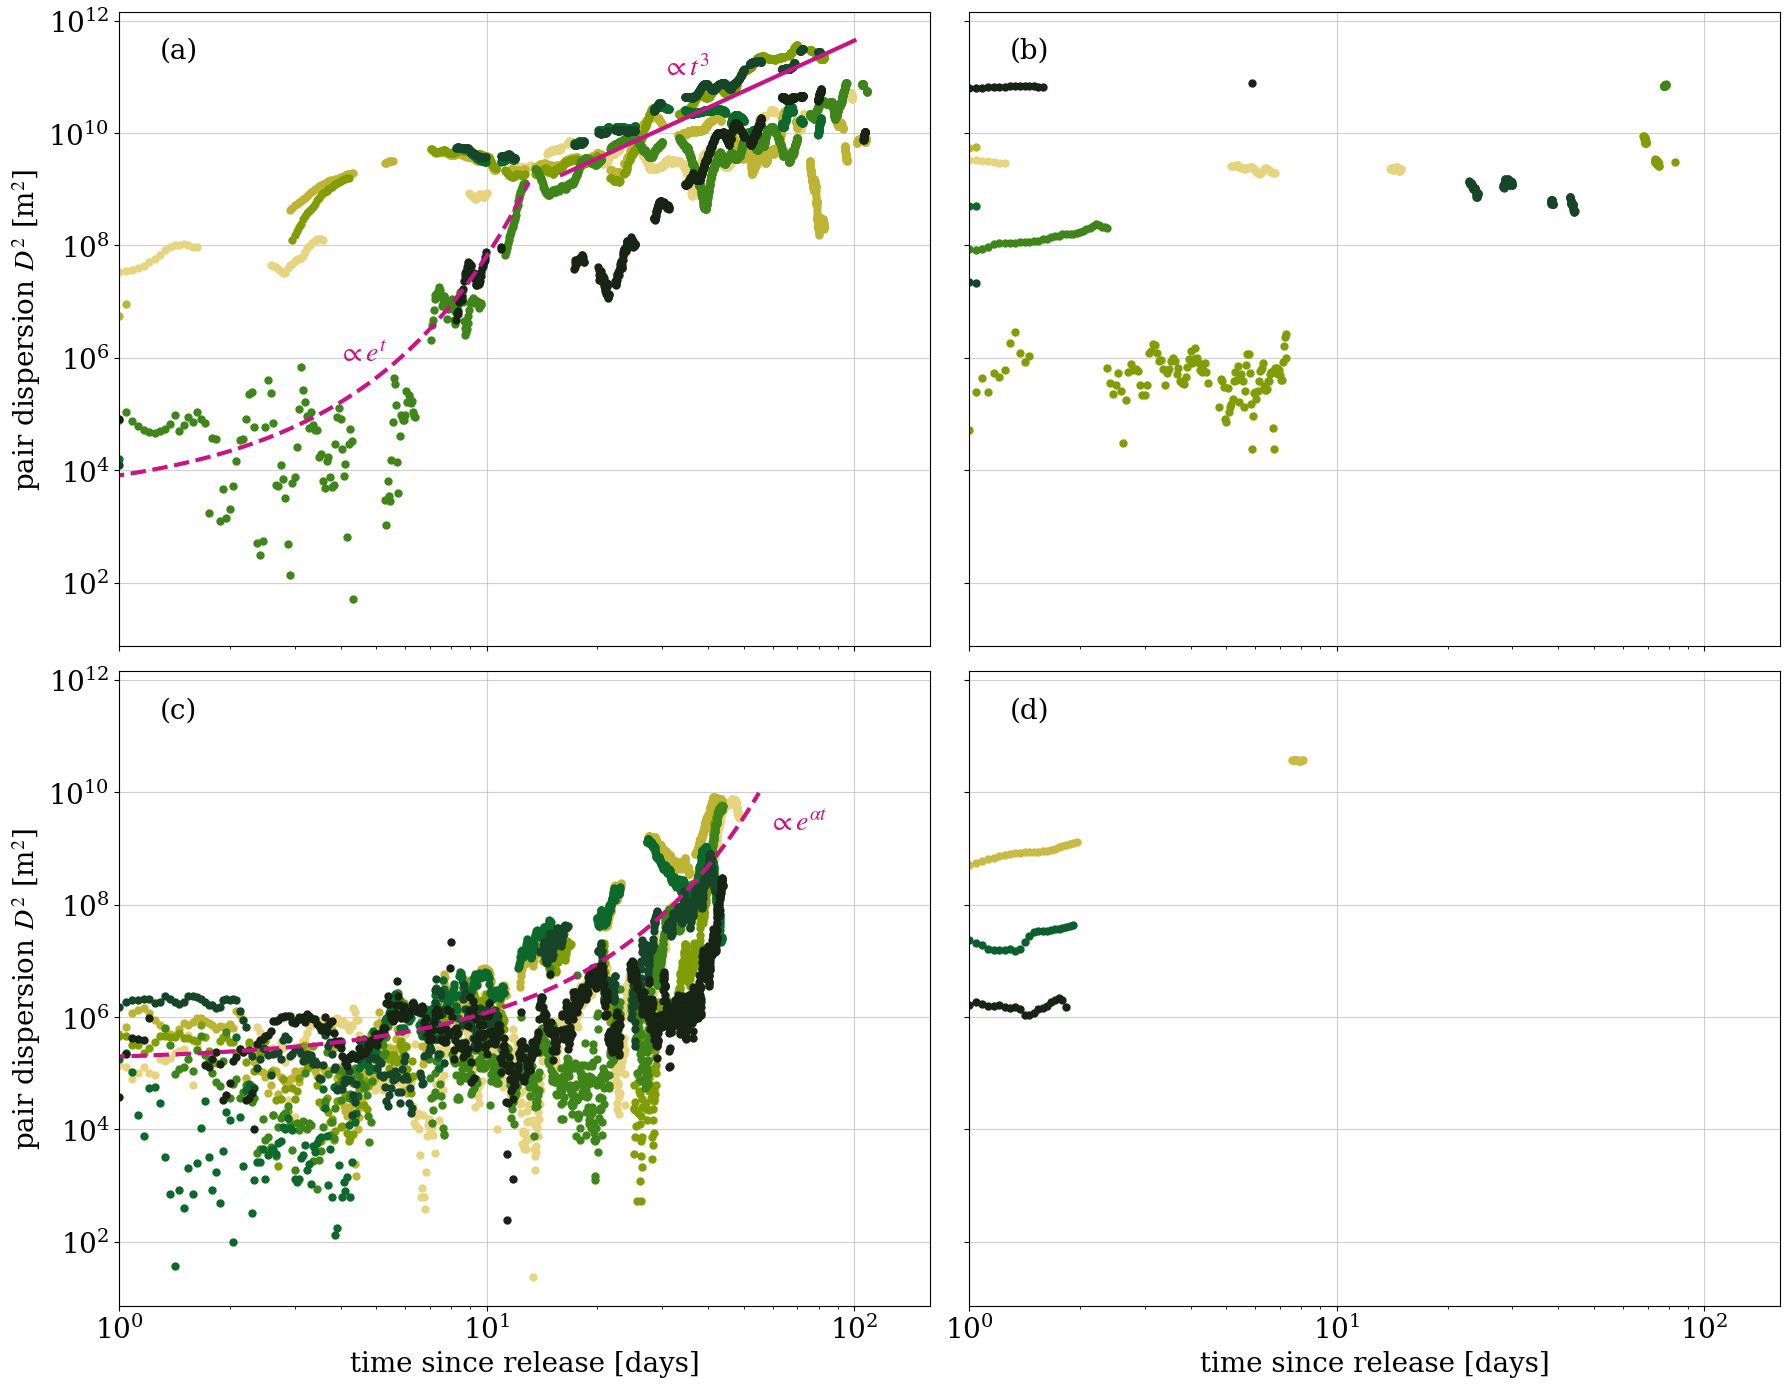

In [ ]:
#| label: fig-pair-dispersion
#| fig-cap: "Pair dispersion for each deployment as a function of the time since release. The colors represent the different pairs. The pink dashed line shows the scaling corresponding to the exponential regime and the solid pink line represents the scaling of the richardson regime. "

# Create first figure for pair dispersion (2x2 grid)
fig1, axes1 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes1 = axes1.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes1[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Pair dispersion vs time
    for i in range(N_pairs):
        try:
            t_pair = ts[mask_pair[i]]
            t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
            t_pair_days = t_pair/(24*60*60)
            ax.plot(t_pair_days, Ds[i]**2, c=cmap((i+1)/N_pairs), marker='o',
                   markersize=5, linestyle='', label=str(i))
        except:
            pass
    
    if idx==0:
        # First deployment
        t_exponential_1 = np.linspace(0, 13, 100)
        d_law_exponential_1 = np.exp(t_exponential_1)/np.exp(-8)
        ax.plot(t_exponential_1, d_law_exponential_1, '--', c = 'mediumvioletred', linewidth=3)

        t_richardson_1 = np.linspace(16, 100, 100)
        ax.plot(t_richardson_1, t_richardson_1**3/np.exp(-13), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.27, 0.45, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==2:
        # Third deployment
        a_3 = 5
        t_exponential_3 = np.linspace(0, 55, 100)
        d_law_exponential_3 = np.exp(t_exponential_3/a_3)/np.exp(-12)
        ax.plot(t_exponential_3, d_law_exponential_3, '--', c = 'mediumvioletred', linewidth=3)

        # t_richardson = np.linspace(0, 100, 100)
        # ax.plot(t_richardson, t_richardson**3/np.exp(-8), '-', c = 'mediumvioletred', linewidth=2)
        # ax.plot(t_richardson, t_richardson/np.exp(-13), ':', c = 'mediumvioletred', linewidth=2)

        ax.text(0.80, 0.75, r'$\propto e^{\alpha t}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        #ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    

    # Add letter annotation in upper left corner
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.6)
    ax.set_xlim(xmin=1)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('time since release [days]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('pair dispersion $D^2$ [m$^2$]')

plt.tight_layout()
plt.show()

The rate of change of separation, or pair diffusivity, has been calculated using @eq-diffusivity and is shown in @fig-pair-diffusivity. Both regimes are shown for all deployments. For the first one, it does not seem to be so clear that there are two regimes, as it was in @fig-pair-dispersion (a). The third one, however, shows one clear tendency where $K \propto D^2$. The second and fourth deployment do not have enough data to determine the regime that governs its dynamics.

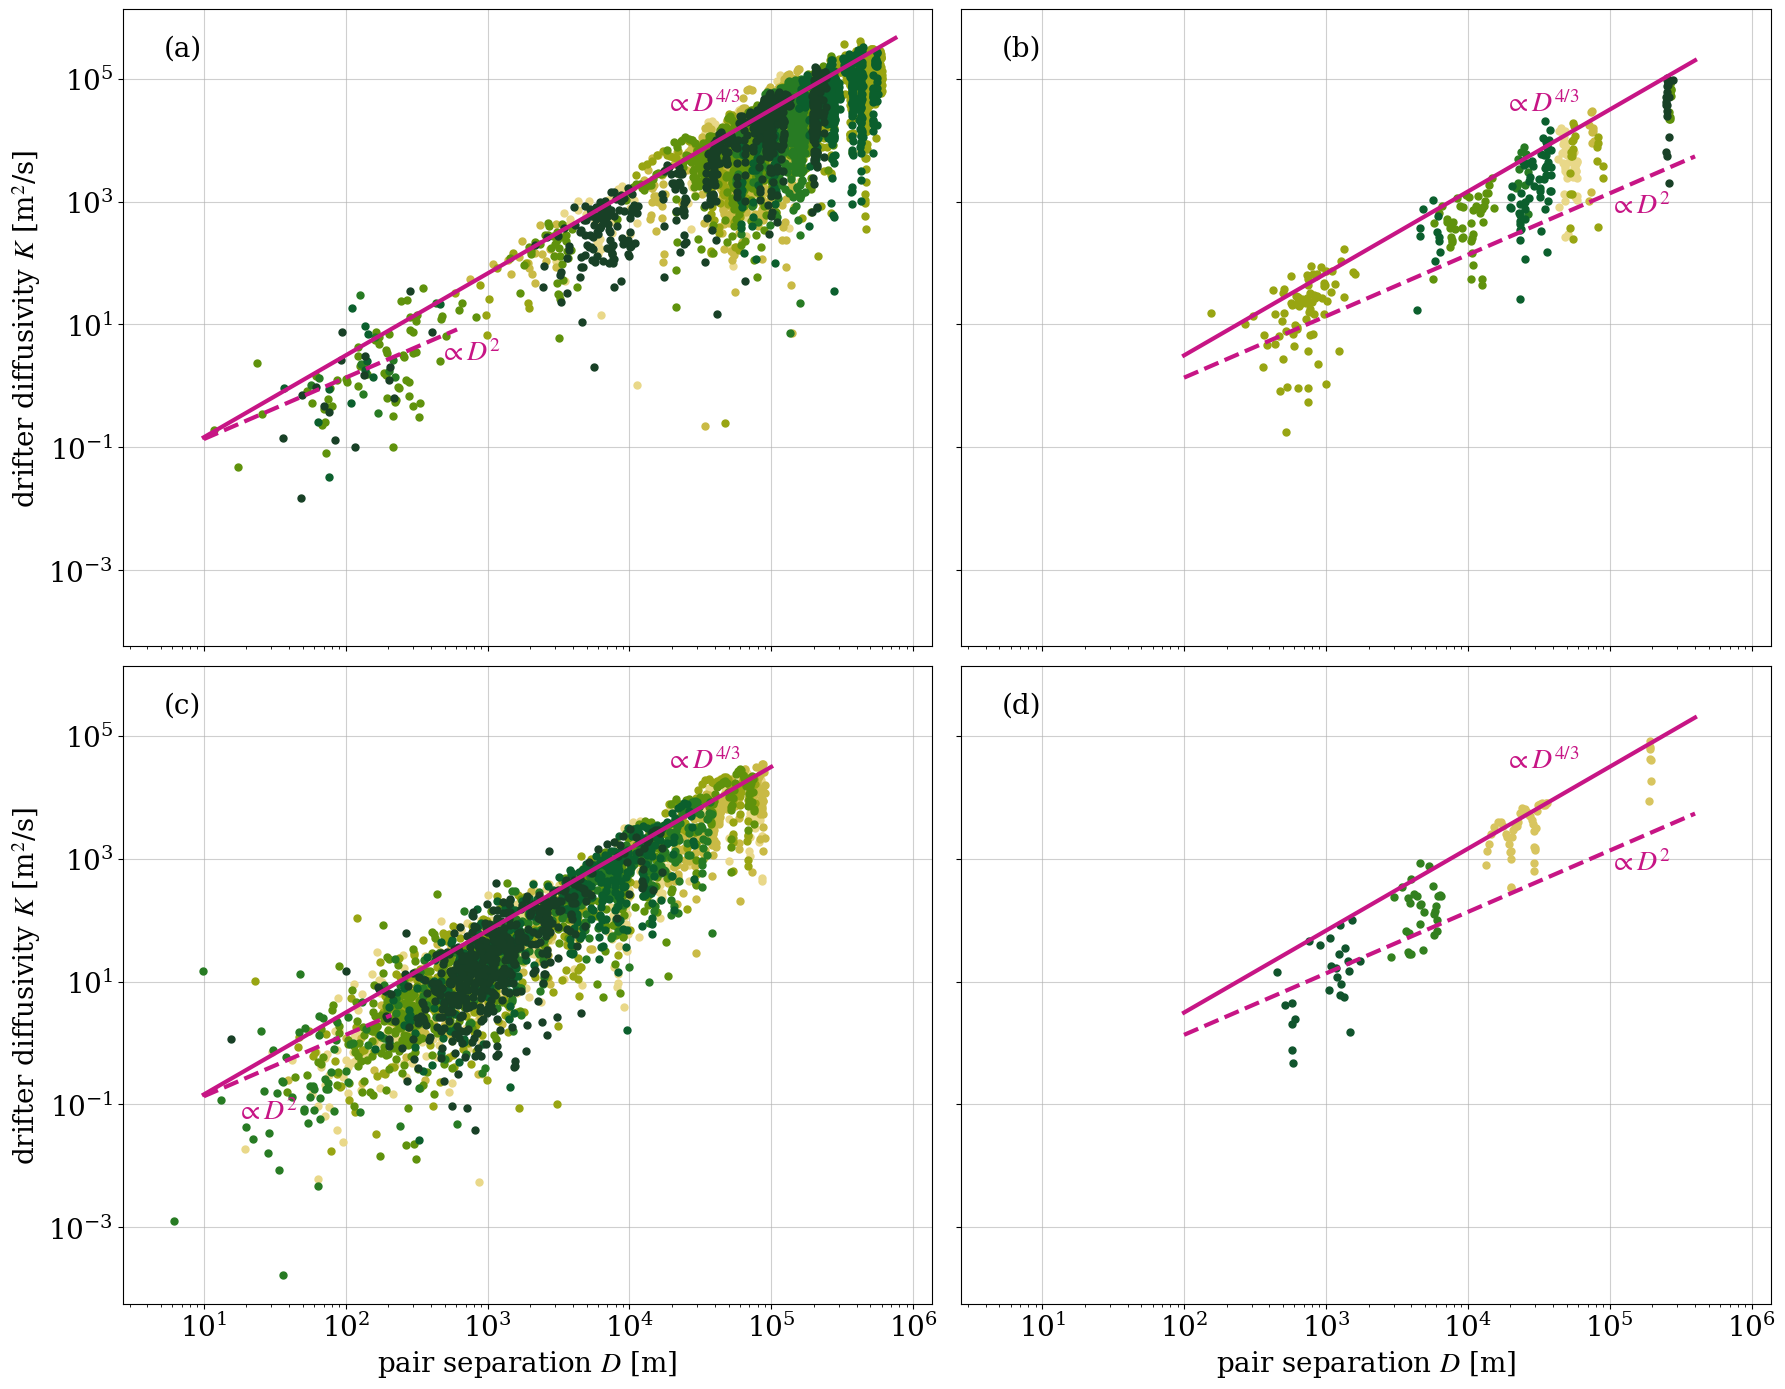

In [19]:
#| label: fig-pair-diffusivity
#| fig-cap: "Pair diffusivity as a function of the distance between pairs. The colors represent the different pairs. The pink dashed line shows the scaling corresponding to the exponential regime and the solid pink line represents the scaling of the richardson regime. "

# Create second figure for diffusivity (2x2 grid)
fig2, axes2 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes2 = axes2.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes2[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Diffusivity vs pair separation
    for i in range(N_pairs):
        ax.plot(Ds[i], Ks[i], c=cmap((i+1)/(N_pairs+1)), marker='o',
               markersize=5, linestyle='', label=str(i))

    if idx==0:
        # Frist deployment
        d_k_exponential_1 = np.arange(10, np.sqrt(np.exp(t_exponential_1[-1])),100)
        ax.plot(d_k_exponential_1, d_k_exponential_1/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_1 = np.arange(10, 0.75*10e5, 100)
        ax.plot(d_k_richardson_1, d_k_richardson_1**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.39, 0.45, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==1:
        # Second deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    
        
    if idx==2:
        # Third deployment
        d_k_exponential_3 = np.arange(10, np.sqrt(np.exp(t_exponential_3[-1]/a_3)),100)
        ax.plot(d_k_exponential_3, d_k_exponential_3/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_3 = np.arange(10, 10e4, 100)
        ax.plot(d_k_richardson_3, d_k_richardson_3**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.14, 0.29, r'$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==3:
        # Fourth deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.6)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('pair separation $D$ [m]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.tight_layout()
plt.show()